In [ ]:
import sys
import os
from pathlib import Path

# Add project root to Python path to enable simcore imports
# The notebook is in simcore/examples/, so go up 2 levels to reach project root
project_root = Path(__file__).parent.parent.parent if '__file__' in globals() else Path.cwd().parent.parent
sys.path.insert(0, str(project_root))

import numpy as np
import matplotlib.pyplot as plt

from simcore.dynamic.components.dc_generator import DCGenerator
from simcore.dynamic.components.motor_dc import MotorDCComponent
from simcore.dynamic.network.network import Network
from simcore.dynamic.network.graph import NetworkGraph, Node
from simcore.dynamic.solver.integrate import run_sim

In [12]:
import numpy as np

# --- Parametri (metti i tuoi) ---
V_gen = 48.0         # V
R_gen = 0.5         # Ohm (resistenza interna generatore)
R0 = 0.1             # Ohm (resistenza avvolgimenti a T0)
alpha = 0.0039       # coeff. temperatura rame [1/K]
T0 = 293.0           # K (20°C)
T_amb = 293.0        # K ambiente

k_e = 0.1            # V*s/rad
k_t = 0.1            # N*m/A

b_motor = 0.01       # N*m*s/rad
b_load = 0.02        # carico viscoso
b_tot = b_motor + b_load

R_th = 0.1           # K/W (più piccolo = più scambio termico)
# -------------------------------

# Iterazione punto fisso
T = T_amb   # inizializzazione
for _ in range(2000):
    R_T = R0 * (1 + alpha * (T - T0))
    # velocità in equilibrio meccanico
    # k_t * i = b_tot * ω  ⇒  ω = (k_t/b_tot) * i
    # ma anche i = (V - k_e*ω)/(R_gen + R_T)
    # quindi usiamo sostituzione diretta:
    # i = (V - k_e*(k_t/b_tot)*i)/(R_gen + R_T)  ⇒ risolvi per i:
    
    denom = (R_gen + R_T) + (k_e * k_t) / b_tot
    i = V_gen / denom
    omega = (k_t / b_tot) * i
    
    # equilibrio termico: T - T_amb = R_th * i^2 * R(T)
    T_new = T_amb + R_th * (i**2) * R_T
    
    # aggiornamento rilassato per stabilità numerica
    T = 0.3*T_new + 0.7*T

# stampa risultato
print(f"Corrente     i  = {i:.3f} A")
print(f"Velocità  omega = {omega:.3f} rad/s  ({omega*60/(2*np.pi):.1f} rpm)")
print(f"Temperatura   T = {T:.2f} K  = {T-273.15:.2f} °C")
print(f"Resistenza R(T)= {R_T:.3f} Ohm")
print(f"Dissipazione  = {i**2 * R_T:.1f} W")


Corrente     i  = 50.819 A
Velocità  omega = 169.396 rad/s  (1617.6 rpm)
Temperatura   T = 321.72 K  = 48.57 °C
Resistenza R(T)= 0.111 Ohm
Dissipazione  = 287.2 W


In [19]:
# --- Parametri simulazione ---
dt = 1e-1
T = 1000
N = int(T / dt)

# --- Nodo bus + ground ---
bus = Node("bus")
gnd = Node("gnd", is_ground=True)

G = NetworkGraph()
G.add_branch("Gen", bus, gnd)   # Generatore → impone tensione
G.add_branch("Motor", bus, gnd) # Motore → preleva corrente

# --- Carico viscoso per il motore ---
def tau_load(t, omega):
    return 0.02 * omega

def dtau_domega(t, omega):
    return 0.02

# --- Componenti ---
components = {

    "Gen": DCGenerator(
        V_nom=48.0,      # Generator voltage
        R_internal=0.05  # Slightly resistive
    ),

    "Motor": MotorDCComponent(
        R0=0.05,
        alpha=0.0039,
        T0=293.15,
        L=2e-3,
        k_e=0.05,
        k_t=0.05,
        J=5e-4,
        b=1e-3,
        tau_load=tau_load,
        dtau_domega=dtau_domega,
        C_th=500.0,
        R_th=0.05,
        T_amb=293.15,
        i0=0.0,
        omega0=0.0,
        T0_state=293.15
    )
}

# --- Costruisci rete ---
net = Network(G, components, dt=dt)

# tensione iniziale nodo bus = V_nom del generatore
v0 = np.array([48.0])

result = run_sim(net, t_stop=T, v0_nodes=v0)



In [ ]:
from simcore.dynamic.components.base import EvalContext


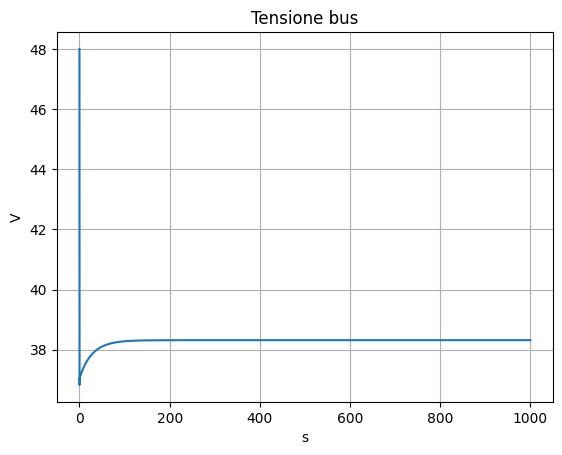

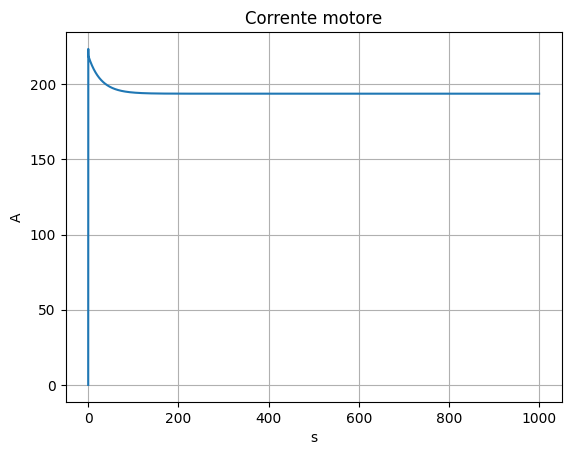

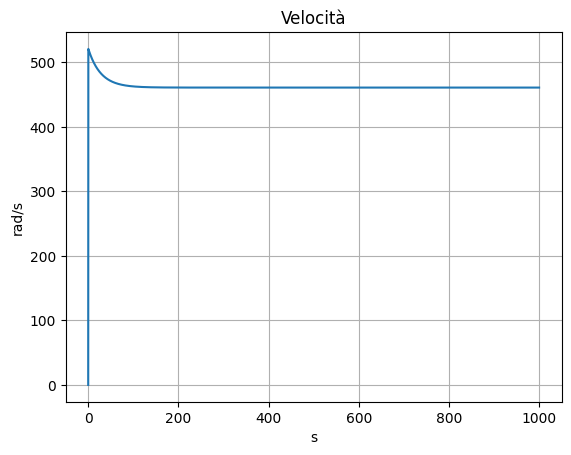

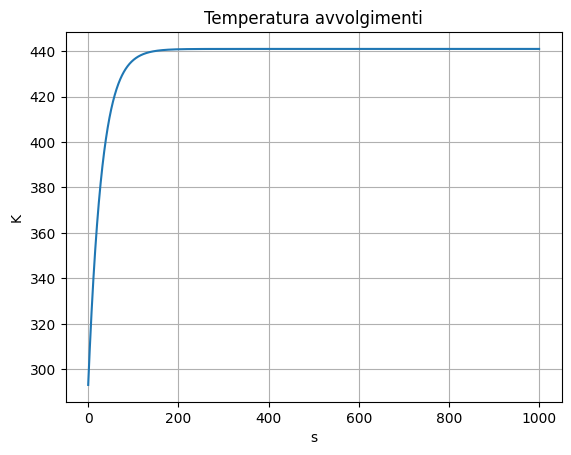

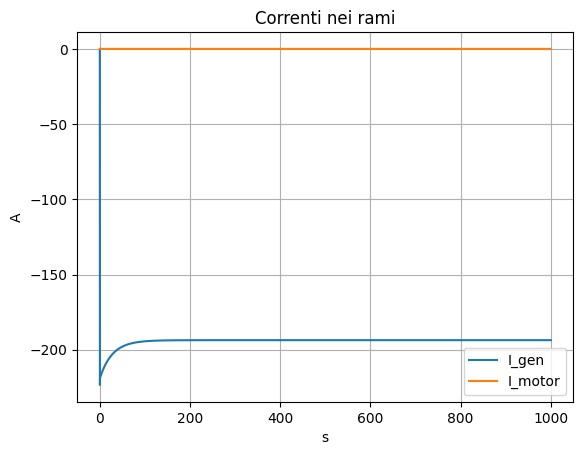

In [21]:


# --- Estrazione stati ---
t = result.t
v_bus = result.v_nodes[0]
z = np.array(result.z_hist)   # shape: time × (i, ω, T)
i = z[:,0]
omega = z[:,1]
T_m = z[:,2]

# Correnti ramo generatore e motore
A = net.A
v = result.v_nodes
dvdt = np.diff(v, prepend=v[:,0:1]) / dt
currents = []
for k in range(len(t)):
    vb = (A.T @ v[:,k])
    dvb = (A.T @ dvdt[:,k])
    row=[]
    for name,comp in components.items():
        b_idx = net.branch_names.index(name)   

        ctx = EvalContext(
            v_branch=float(vb[b_idx]),
            dvdt_branch=float(dvb[b_idx]),
            t_next=float(t[k]),
            dt=dt
        )

        row.append(comp.current(ctx, z_next=None))
        
    currents.append(row)
currents=np.array(currents)
I_gen = currents[:,0]
I_motor = currents[:,1]

# --- PLOT ---
plt.figure(); plt.plot(t, v_bus); plt.title("Tensione bus"); plt.grid(); plt.xlabel("s"); plt.ylabel("V")

plt.figure(); plt.plot(t, i); plt.title("Corrente motore"); plt.grid(); plt.xlabel("s"); plt.ylabel("A")

plt.figure(); plt.plot(t, omega); plt.title("Velocità"); plt.grid(); plt.xlabel("s"); plt.ylabel("rad/s")

plt.figure(); plt.plot(t, T_m); plt.title("Temperatura avvolgimenti"); plt.grid(); plt.xlabel("s"); plt.ylabel("K")

plt.figure(); plt.plot(t, I_gen, label="I_gen"); plt.plot(t, I_motor, label="I_motor"); 
plt.legend(); plt.grid(); plt.title("Correnti nei rami"); plt.xlabel("s"); plt.ylabel("A")

plt.show()
